In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
# Cell 1: imports & setup
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

gc.enable()

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageTabDataset
from src.models import EarlyFusionNet
from src.train import train_one_epoch_fusion, validate_fusion


main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp5")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp5"]   # define in config
TARGET = "Pawpularity"
tab_cols = [c for c in df.columns if c not in ["Id", TARGET]]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/ghias/miniconda3/envs/rapids-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# KFold CV training loop for Exp5 (Swin-T + metadata, strong aug, BCE/MSE)

# backbone_name = cfg["backbone"]              # "swin_tiny_patch4_window7_224" OR swin_large_patch4_window12_384
backbone_name = "swin_large_patch4_window12_384.ms_in22k"
img_size = cfg["img_size"]                   # 384
aug_type = cfg["aug"]                        # "strong"
loss_name = cfg["loss"]                      # "bce" 
head_type = cfg["head_type"]                 # "mlp" recommended

n_splits = cfg["n_splits"]
epochs = cfg["epochs"]
batch_size = cfg["batch_size"]

lr = cfg["lr"]
weight_decay = cfg["weight_decay"]
patience = cfg["patience"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
fold_rmse = []
start = time.time()
for fold, (tr_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n=== {cfg['name']}: Fold {fold+1} ===")

    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_tf = build_transforms(img_size, aug_type, train=True)
    val_tf = build_transforms(img_size, aug_type, train=False)

    train_ds = ImageTabDataset(train_df, img_folder, tab_cols, train_tf)
    val_ds = ImageTabDataset(val_df, img_folder, tab_cols, val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True,pin_memory=True, persistent_workers=True, num_workers=16)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False,pin_memory=True,persistent_workers=True, num_workers=16)

    model = EarlyFusionNet(
        backbone_name=backbone_name,
        img_size=img_size,
        tab_input_dim=len(tab_cols),
        head_type=head_type,
        pretrained=True,
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

    if loss_name == "bce":
        criterion = torch.nn.BCEWithLogitsLoss()
        scale_target = True
    else:
        criterion = torch.nn.MSELoss()
        scale_target = False

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    scaler = torch.amp.GradScaler("cuda")
    best_rmse = 1e10
    best_state = None
    epochs_no_improve = 0
    train_losses, val_rmses = [], []

    epoch_logs = []
    for epoch in range(epochs):
        avg_train_loss = train_one_epoch_fusion(
            model, train_loader, optimizer, criterion, device, scaler, scale_target
        )
        scheduler.step()

        rmse, val_preds, val_targets = validate_fusion(
            model, val_loader, device, scale_target
        )
        train_losses.append(avg_train_loss)
        val_rmses.append(rmse)

        print(f"Epoch {epoch+1}/{epochs} | Fold {fold+1} "
              f"TrainLoss: {avg_train_loss:.4f} ValRMSE: {rmse:.4f}")
        epoch_logs.append({
            "fold": fold + 1,
            "epoch": epoch + 1,
            "train_loss": float(avg_train_loss),
            "val_rmse": float(rmse),
        })

        if rmse < best_rmse:
            best_rmse = rmse
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    pd.DataFrame(epoch_logs).to_csv(
        os.path.join(out_dir, f"epoch_logs_fold{fold+1}.csv"), index=False
    )
    
    hist_df = pd.DataFrame({
        "epoch": range(1, len(train_losses)+1),
        "train_loss": train_losses,
        "train_rmse": np.sqrt(train_losses) if loss_name == "mse" else np.nan,
        "val_rmse": val_rmses,
    })
    hist_df.to_csv(os.path.join(out_dir, f"history_fold{fold+1}.csv"),
                   index=False)

    model.load_state_dict(best_state)
    _, val_preds, _ = validate_fusion(
        model, val_loader, device, scale_target
    )
    oof_pred[val_idx] = val_preds
    fold_rmse.append(best_rmse)
    print(f"Fold {fold+1} best RMSE: {best_rmse:.4f}")

    torch.save(best_state,
               os.path.join(out_dir, f"model_fold{fold+1}.pt"))
    
    # Clear memory
    del model, optimizer, train_loader, val_loader, train_ds, val_ds
    torch.cuda.empty_cache()
    gc.collect()

all_sec = time.time() - start
print(f"\nTotal training time: {int(all_sec//60)}m {int(all_sec%60)}s")




=== Exp5_SwinT_384_Strong_TabMLP_Early_MLPHead: Fold 1 ===
Epoch 1/10 | Fold 1 TrainLoss: 0.6494 ValRMSE: 18.0146
Epoch 2/10 | Fold 1 TrainLoss: 0.6384 ValRMSE: 17.8099
Epoch 3/10 | Fold 1 TrainLoss: 0.6285 ValRMSE: 17.7761
Epoch 4/10 | Fold 1 TrainLoss: 0.6165 ValRMSE: 18.2033
Epoch 5/10 | Fold 1 TrainLoss: 0.6046 ValRMSE: 18.4082
Epoch 6/10 | Fold 1 TrainLoss: 0.5951 ValRMSE: 18.7210
Epoch 7/10 | Fold 1 TrainLoss: 0.5891 ValRMSE: 18.7312
Epoch 8/10 | Fold 1 TrainLoss: 0.5852 ValRMSE: 18.8132
Early stopping at epoch 8
Fold 1 best RMSE: 17.7761

=== Exp5_SwinT_384_Strong_TabMLP_Early_MLPHead: Fold 2 ===
Epoch 1/10 | Fold 2 TrainLoss: 0.6479 ValRMSE: 18.3243
Epoch 2/10 | Fold 2 TrainLoss: 0.6371 ValRMSE: 18.5132
Epoch 3/10 | Fold 2 TrainLoss: 0.6280 ValRMSE: 18.0847
Epoch 4/10 | Fold 2 TrainLoss: 0.6159 ValRMSE: 18.3777
Epoch 5/10 | Fold 2 TrainLoss: 0.6041 ValRMSE: 18.7856
Epoch 6/10 | Fold 2 TrainLoss: 0.5947 ValRMSE: 19.0974
Epoch 7/10 | Fold 2 TrainLoss: 0.5885 ValRMSE: 18.9982
Epo

In [4]:
# final OOF metrics
oof_rmse = root_mean_squared_error(df[TARGET], oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "ytrue": df[TARGET],
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")


OOF RMSE: 18.8852
Fold RMSEs: [17.776094436645508, 18.084693908691406, 17.339855194091797, 17.852365493774414, 17.942861557006836]  Mean=17.7992  Std=0.2516


### Visualization

In [16]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import torch
from torchvision import transforms


def overlay_cam_on_pil(pil_image, cam_mask):
    """
    Resize CAM to image size before overlay.
    """
    rgb = np.array(pil_image).astype(np.float32) / 255.0          # [H,W,3]
    h, w, _ = rgb.shape

    # cam_mask is [Hc, Wc]; resize to [H,W]
    cam_img = Image.fromarray((cam_mask * 255).astype(np.uint8))
    cam_img = cam_img.resize((w, h), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img).astype(np.float32) / 255.0    # [H,W]

    vis = show_cam_on_image(rgb, cam_resized, use_rgb=True)
    return vis


def compute_gradcam_for_image(
    model,
    pil_image,
    img_size,
    target_layer,
    device="cuda",
):
    """
    Generic Grad-CAM for CNN / Swin timm backbones.
    target_layer must output [B, C, H, W] OR [B, H, W, C].
    """
    tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    img_tensor = tf(pil_image).unsqueeze(0)  # [1,C,H,W]

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # For Swin (timm), norm1 is applied to [B, H, W, C].
    # GradCAM can handle this; no custom reshape needed.
    cam = GradCAM(
        model=model,
        target_layers=[target_layer],
    )
    grayscale_cam = cam(input_tensor=img_tensor.to(device))[0]
    return grayscale_cam, img_tensor.squeeze(0)


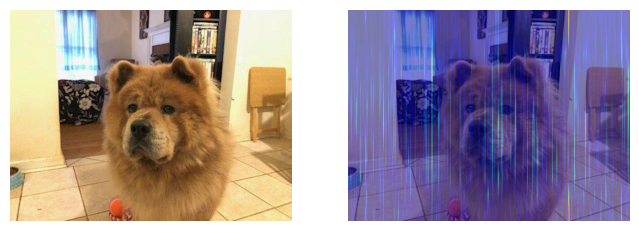

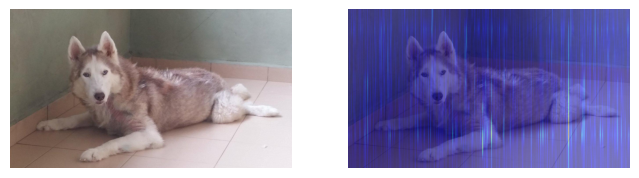

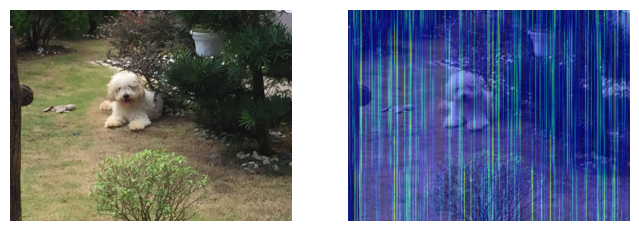

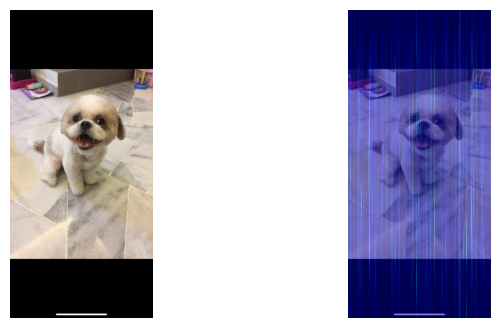

In [17]:
from src.models import EarlyFusionNet
from PIL import Image

fold_to_vis = 1
model_path = os.path.join(out_dir, f"model_fold{fold_to_vis}.pt")

model = EarlyFusionNet(
    backbone_name=backbone_name,
    img_size=img_size,
    tab_input_dim=len(tab_cols),
    head_type=head_type,
    pretrained=False,
)
model.load_state_dict(torch.load(model_path, map_location="cpu"))

err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

for _, row in err_df.head(4).iterrows():
    img_id = row.Id
    pil_img = Image.open(os.path.join(img_folder, f"{img_id}.jpg")).convert("RGB")
    cam_mask, _ = compute_gradcam_for_image(
    model.img_model, pil_img, img_size,
    target_layer=model.img_model.layers[-1].blocks[-1].norm1,
    )
    overlay = overlay_cam_on_pil(pil_img, cam_mask)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(pil_img); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off")
    plt.show()


In [19]:
def swin_block_cam(model, pil_image, img_size, device="cuda"):
    """
    CAM-like map from the last Swin block output (treated as [B,H,W,C]).
    model: timm Swin backbone
    """
    val_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    img_tensor = val_tf(pil_image).unsqueeze(0)

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    target_layer = model.layers[-1].blocks[-1]

    def reshape_transform(tensor):
        if tensor.dim() == 4:          # [B,H,W,C]
            B, H, W, C = tensor.shape
            return tensor.permute(0, 3, 1, 2)  # [B,C,H,W]
        return tensor

    cam = GradCAM(
        model=model,
        target_layers=[target_layer],
        reshape_transform=reshape_transform,
    )
    grayscale_cam = cam(input_tensor=img_tensor.to(device))[0]

    rgb = np.array(pil_image).astype(np.float32) / 255.0
    h, w, _ = rgb.shape
    cam_img = Image.fromarray((grayscale_cam * 255).astype(np.uint8))
    cam_img = cam_img.resize((w, h), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img).astype(np.float32) / 255.0
    vis = show_cam_on_image(rgb, cam_resized, use_rgb=True)
    return vis


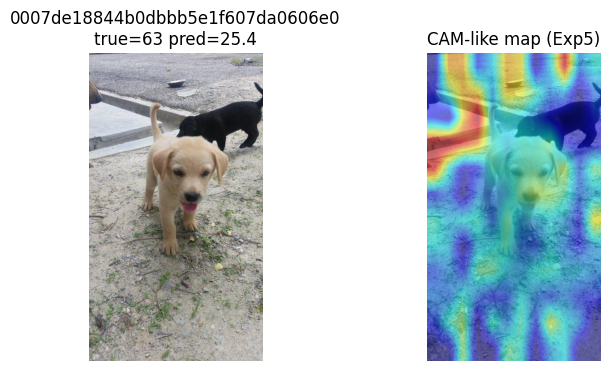

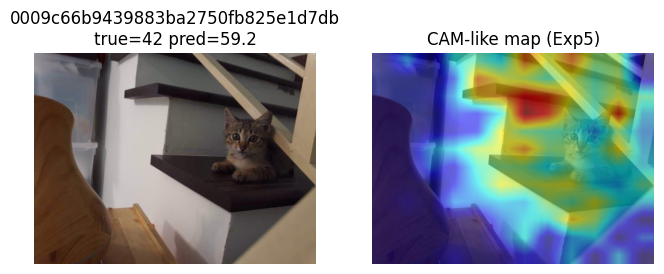

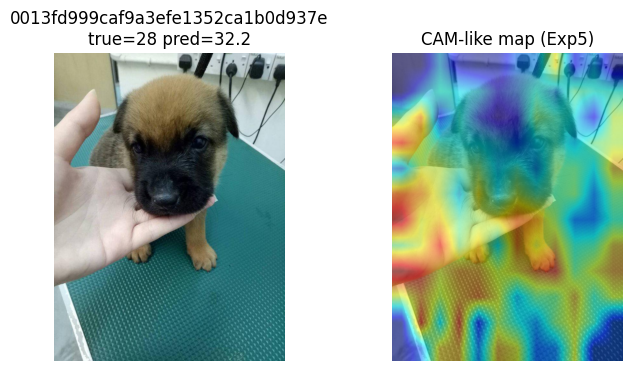

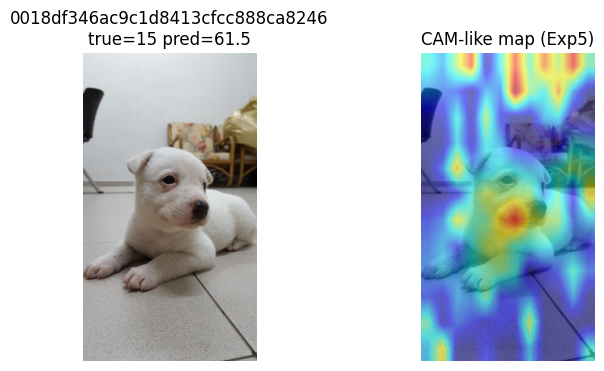

In [21]:
from src.models import EarlyFusionNet
from PIL import Image

fold_to_vis = 1
model_path = os.path.join(out_dir, f"model_fold{fold_to_vis}.pt")

fusion_model = EarlyFusionNet(
    backbone_name=backbone_name,   # Swin backbone from cfg
    img_size=img_size,
    tab_input_dim=len(tab_cols),
    head_type=head_type,
    pretrained=False,
)
fusion_model.load_state_dict(torch.load(model_path, map_location="cpu"))

swin_backbone = fusion_model.img_model  # this is the Swin used in Exp5

err_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))

for _, row in err_df.head(4).iterrows():
    img_id = row.Id
    pil_img = Image.open(os.path.join(img_folder, f"{img_id}.jpg")).convert("RGB")

    overlay = swin_block_cam(swin_backbone, pil_img, img_size, device="cuda")

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(pil_img); plt.axis("off")
    plt.title(f"{img_id}\ntrue={row.ytrue} pred={row.oof_pred:.1f}")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off")
    plt.title("CAM-like map (Exp5)")
    plt.show()
